# Function Approximation

In [1]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from utils import plot

In [2]:
# %matplotlib widget
%matplotlib inline

## Network Definition

In [3]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam,
        use_grad=False):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True),
                nn.LeakyReLU(),
                nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)
            )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        self.use_grad = use_grad
        
    def forward(self, x):
        out = self.layers(x)
        return out

    def loss(self, x, y, y_grad=None):
        out = self.forward(x)
        loss = self.loss_func(y, out)
        if self.use_grad:
            out_grad = torch.autograd.grad(out, x, torch.ones(x.shape), create_graph=True)[0]
            loss += self.loss_func(y_grad, out_grad)
        return loss
    
    def step(self, x, y, y_grad=None):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, y, y_grad)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss.detach()

## 1D

### KFold-Cross Validation

In [4]:
from DatasetFunction1D import DatasetFunction1D
from torch.utils.data import DataLoader

x = torch.linspace(-1,1, 100, requires_grad=True).reshape(-1,1)
dataset = DatasetFunction1D(x)
_, y, y_grad = dataset[:]

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

N_in = x.shape[1]
N_out = y.shape[1]

In [5]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

K = 2 # Number of folds
kfold = KFold(n_splits=K, shuffle=True)
batch_size = 10
epochs = 100

In [6]:
losses_train = torch.zeros(K, epochs)
losses_test = torch.zeros(K)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print('FOLD: ' + str(fold))
    train_sampler = SubsetRandomSampler(train_ids)
    train_loader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size,
                        sampler=train_sampler)

    net = Net(N_in, N_out, N_hid=100, use_grad=True)

    for epoch in range(epochs):
        current_loss = 0.0
        for i, batch in enumerate(train_loader):
            x_train, y_train, y_train_grad = batch
            current_loss += net.step(x_train, y_train, y_train_grad)
        losses_train[fold, epoch] = current_loss / (i+1)
    
    # Evaluation for this fold
    x_test, y_test, y_grad_test = dataset[test_ids]
    losses_test[fold] = net.loss(x_test, y_test, y_grad_test)

FOLD: 0
FOLD: 1


In [7]:
loss_test = torch.mean(losses_test).detach()
print("Test Loss: {:.3f}".format(loss_test))

Test Loss: 5.517


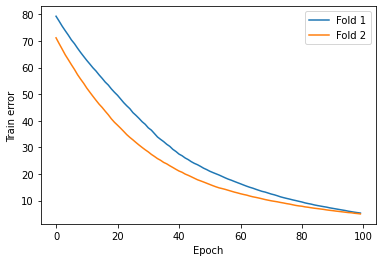

In [8]:
plot(range(epochs), losses_train.T)
plt.legend(['Fold ' + str(e+1) for e in range(epochs)])
plt.xlabel('Epoch')
plt.ylabel('Train error')
plt.show()

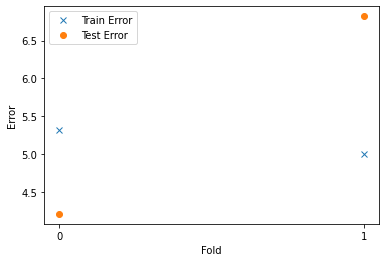

In [9]:
plot(range(K), losses_train[:,-1], 'x')
plot(range(K), losses_test, 'o')
plt.legend(['Train Error', 'Test Error'])
plt.xlabel('Fold')
plt.ylabel('Error')
plt.xticks(range(K))
plt.show()